In [1]:
import functions as mf
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
from scipy.special import lambertw

In [2]:
# Define the grid
Ny = 1000
y_end = 10

# Define flow parameters
rho = 1
mu_0 = 1 
pressure_difference = 1
pressure_boundary = [4, 4]
boundary_condition = [1, 1]


system = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
mu = system.calc_mu(mu_0)

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


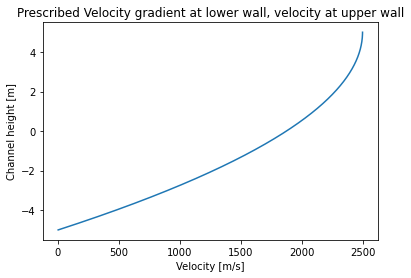

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


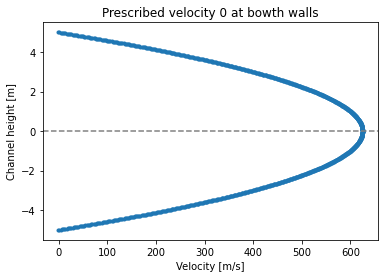

prescribed shear stress at wall


C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


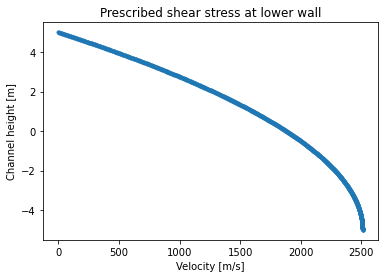

In [3]:
# velocity gradient is 0 at wall 1, velocity set at wall 2
boundary_condition = [1,-1]
pressure_boundary = [0, 0]
system_velocity_gradient = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_gradient.simulate(mu)
plt.plot(solution[1:-1], system_velocity_gradient.y[1:-1])
plt.title("Prescribed Velocity gradient at lower wall, velocity at upper wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.show()

# velocity is 0 at wall
boundary_condition = [1, 1]
system_velocity_zero = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_zero.simulate(mu)
plt.title("Prescribed velocity 0 at bowth walls")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_zero.y, '.')
plt.axhline(0, color='grey', linestyle='dashed')
plt.show()

# prescribed shear stress at wall
print("prescribed shear stress at wall")
stress = 1
boundary_condition = [-1, 1]
pressure_boundary = [-stress * (y_end / Ny) / mu[0], 0]
system_velocity_shear_stress = mf.Multiflow(Ny, y_end, rho, pressure_difference ,pressure_boundary, boundary_condition, mu_0)
solution = system_velocity_shear_stress.simulate(mu)
plt.title("Prescribed shear stress at lower wall")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.plot(solution,system_velocity_shear_stress.y, '.')
plt.show()


prantl mixing length

C:\Users\brent\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


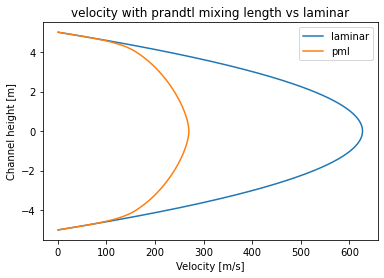

In [8]:
argument_type = "Spalding"
mu = system.calc_mu(mu_0)
velocity_laminar = system.simulate(mu)

velocity_new = velocity_laminar

# Then calculate the solution with Prandtl mixing length
eps = 0.01
error = 1
i = 0

# Looping till solution converges
while error > eps:
    velocity = velocity_new

    # Calculate new effective viscosity
    mu_Prandtl = system.calc_mu_Prandtl(velocity, argument_type)

    # Calculate ensuing velocity
    velocity_new = system.simulate(mu_Prandtl)

    error = np.sum(np.abs((velocity_new - velocity) / velocity))
    i+=1
    print("iteration", i, "with error", error, end='\r')

    if i > 2000:
        print("Oh nyo, it's bwoken")
        break

velocity_turbulent = velocity_new
mu_turbulent = mu_Prandtl

plt.plot(velocity_laminar,system.y, label="laminar")
plt.plot(velocity_new,system.y, label="pml")
plt.title("velocity with prandtl mixing length vs laminar")
plt.xlabel('Velocity [m/s]')
plt.ylabel('Channel height [m]')
plt.legend()
plt.show()


34
